In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.stats
from math import sqrt

from sklearn import preprocessing, metrics, model_selection
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling

## Step 1. Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 –target variables, the rest - predictors).

In [3]:
df = pd.read_csv('continuous dataset.csv')
df.head(10)

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
5,2015-01-03 06:00:00,879.2323,26.034143,0.019080,0.014542,20.062038,22.995081,0.017028,0.001485,9.087273,22.456018,0.016410,0.061539,5.280351,0,0,0
6,2015-01-03 07:00:00,932.4876,26.691492,0.019332,0.006645,21.623496,24.285242,0.017424,0.002176,11.395393,22.949304,0.016570,0.060898,5.126911,0,0,0
7,2015-01-03 08:00:00,1048.9720,27.674066,0.019370,0.006863,23.775317,26.189691,0.018073,0.004539,12.872866,24.088129,0.016677,0.056198,5.060611,0,0,0
8,2015-01-03 09:00:00,1167.9074,28.760400,0.019171,0.010231,24.636152,27.916650,0.018454,0.004292,14.548027,25.479150,0.016646,0.051071,4.915658,0,0,0
9,2015-01-03 10:00:00,1257.5069,29.766656,0.018759,0.009018,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48048 entries, 0 to 48047
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    48048 non-null  object 
 1   nat_demand  48048 non-null  float64
 2   T2M_toc     48048 non-null  float64
 3   QV2M_toc    48048 non-null  float64
 4   TQL_toc     48048 non-null  float64
 5   W2M_toc     48048 non-null  float64
 6   T2M_san     48048 non-null  float64
 7   QV2M_san    48048 non-null  float64
 8   TQL_san     48048 non-null  float64
 9   W2M_san     48048 non-null  float64
 10  T2M_dav     48048 non-null  float64
 11  QV2M_dav    48048 non-null  float64
 12  TQL_dav     48048 non-null  float64
 13  W2M_dav     48048 non-null  float64
 14  Holiday_ID  48048 non-null  int64  
 15  holiday     48048 non-null  int64  
 16  school      48048 non-null  int64  
dtypes: float64(13), int64(3), object(1)
memory usage: 6.2+ MB


In [5]:
df = df.drop(['datetime', 'W2M_toc', 'W2M_san', 'W2M_dav', 'Holiday_ID', 'holiday', 'school'], axis=1)

In [6]:
df.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'T2M_san', 'QV2M_san',
       'TQL_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav'],
      dtype='object')

In [7]:
df.head(10)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,T2M_san,QV2M_san,TQL_san,T2M_dav,QV2M_dav,TQL_dav
0,970.3450,25.865259,0.018576,0.016174,23.482446,0.017272,0.001855,22.662134,0.016562,0.096100
1,912.1755,25.899255,0.018653,0.016418,23.399255,0.017265,0.001327,22.578943,0.016509,0.087646
2,900.2688,25.937280,0.018768,0.015480,23.343530,0.017211,0.001428,22.531030,0.016479,0.078735
3,889.9538,25.957544,0.018890,0.016273,23.238794,0.017128,0.002599,22.512231,0.016487,0.068390
4,893.6865,25.973840,0.018981,0.017281,23.075403,0.017059,0.001729,22.481653,0.016456,0.064362
5,879.2323,26.034143,0.019080,0.014542,22.995081,0.017028,0.001485,22.456018,0.016410,0.061539
6,932.4876,26.691492,0.019332,0.006645,24.285242,0.017424,0.002176,22.949304,0.016570,0.060898
7,1048.9720,27.674066,0.019370,0.006863,26.189691,0.018073,0.004539,24.088129,0.016677,0.056198
8,1167.9074,28.760400,0.019171,0.010231,27.916650,0.018454,0.004292,25.479150,0.016646,0.051071
9,1257.5069,29.766656,0.018759,0.009018,29.172906,0.018675,0.004921,26.704156,0.016608,0.058685


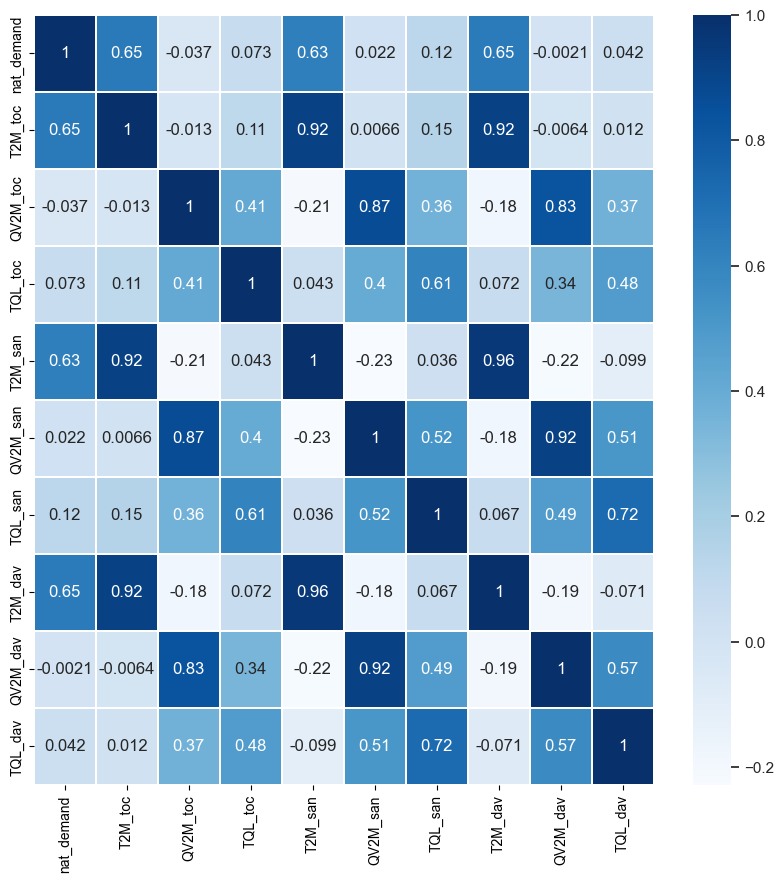

In [8]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df.corr(), cmap='Blues', annot=True, linewidths=0.25)

plt.show()

## Step 2. Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

In [9]:
sampled_df = df.sample(frac=0.5, random_state=0)

In [10]:
import scipy.stats

def inverse_ts(array, dist):
    args = dist.fit(array)
    data = np.random.uniform(size=len(array))
    its = dist(*args)
    its = its.ppf(data)
    return its

its_nat_demand = pd.DataFrame({'nat_demand': inverse_ts(df['nat_demand'], scipy.stats.gamma)})
its_T2M_toc = pd.DataFrame({'T2M_toc': inverse_ts(df['T2M_toc'], scipy.stats.gamma)})
its_T2M_san = pd.DataFrame({'T2M_san': inverse_ts(df['T2M_san'], scipy.stats.gamma)})

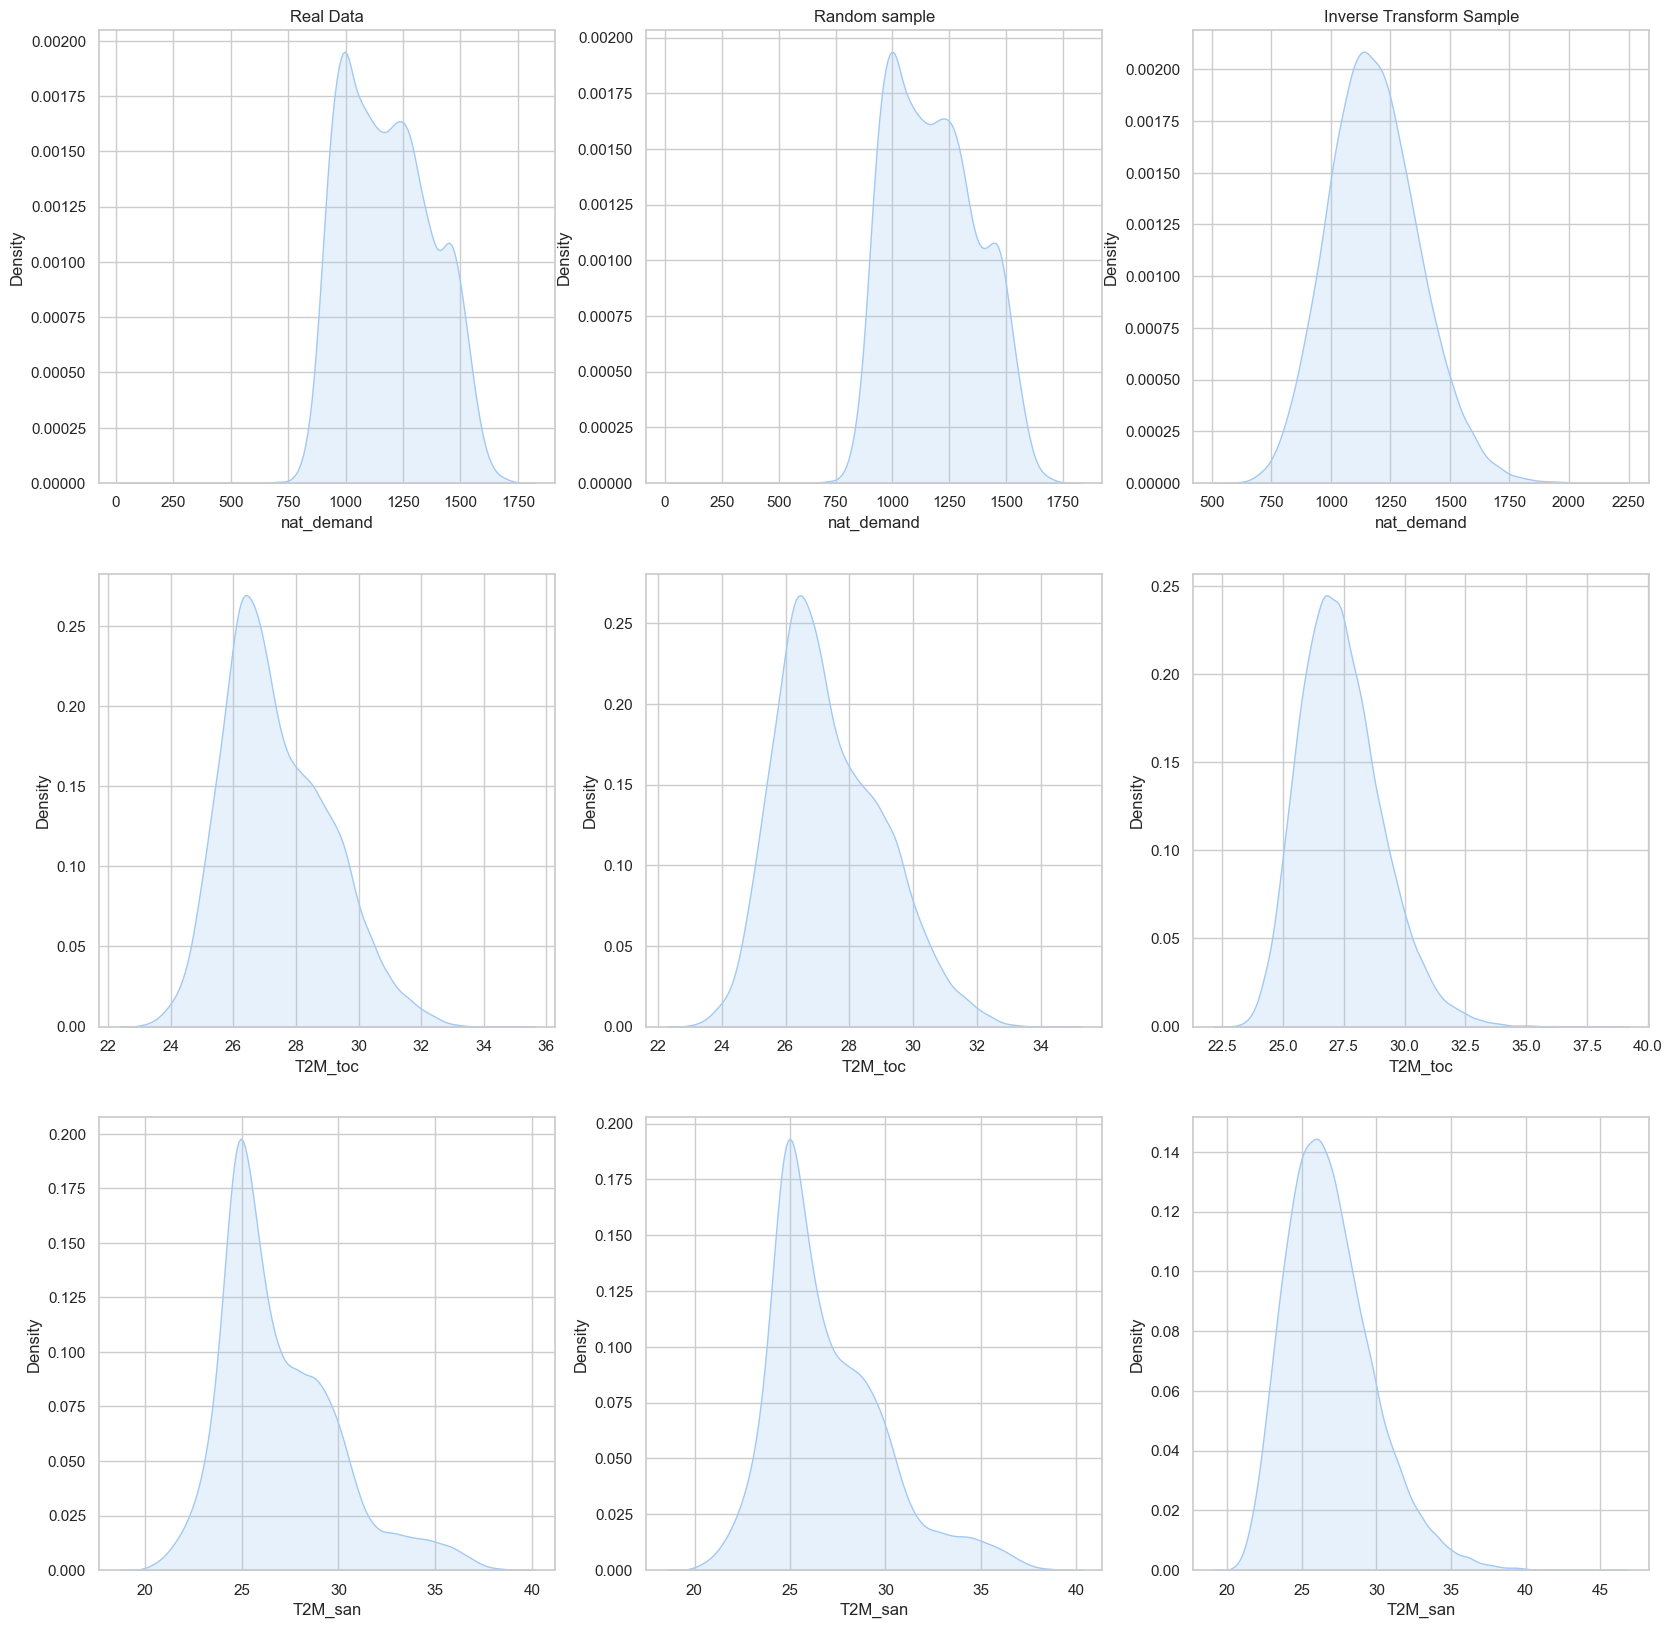

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Random sample')
ax[0, 2].set_title('Inverse Transform Sample')

sns.kdeplot(df['nat_demand'], ax=ax[0, 0], shade=True)
sns.kdeplot(sampled_df['nat_demand'], ax=ax[0, 1], shade=True)
sns.kdeplot(its_nat_demand['nat_demand'], ax=ax[0, 2], shade=True)

sns.kdeplot(df['T2M_toc'], ax=ax[1, 0], shade=True)
sns.kdeplot(sampled_df['T2M_toc'], ax=ax[1, 1], shade=True)
sns.kdeplot(its_T2M_toc['T2M_toc'], ax=ax[1, 2], shade=True)

sns.kdeplot(df['T2M_san'], ax=ax[2, 0], shade=True)
sns.kdeplot(sampled_df['T2M_san'], ax=ax[2, 1], shade=True)
sns.kdeplot(its_T2M_san['T2M_san'], ax=ax[2, 2], shade=True)

plt.savefig('3_1', dpi=600)

plt.show()

In [12]:
random_samp_df = pd.DataFrame(data={
    'nat_demand': sampled_df['nat_demand'],
    'T2M_toc': sampled_df['T2M_toc'],
    'T2M_san': sampled_df['T2M_san']
})

In [13]:
random_samp_df.mean()

nat_demand    1182.557391
T2M_toc         27.397559
T2M_san         26.916552
dtype: float64

In [14]:
random_samp_df.var()

nat_demand    36981.621056
T2M_toc           2.820489
T2M_san           9.155593
dtype: float64

In [15]:
its_df = pd.DataFrame(data={
    'nat_demand': its_nat_demand['nat_demand'],
    'T2M_toc': its_T2M_toc['T2M_toc'],
    'T2M_san': its_T2M_san['T2M_san']
})

In [16]:
its_df.mean()

nat_demand    1182.160136
T2M_toc         27.400568
T2M_san         26.925070
dtype: float64

In [17]:
its_df.var()

nat_demand    36575.991045
T2M_toc           2.836905
T2M_san           8.638608
dtype: float64

## Step 3. Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

<AxesSubplot:>

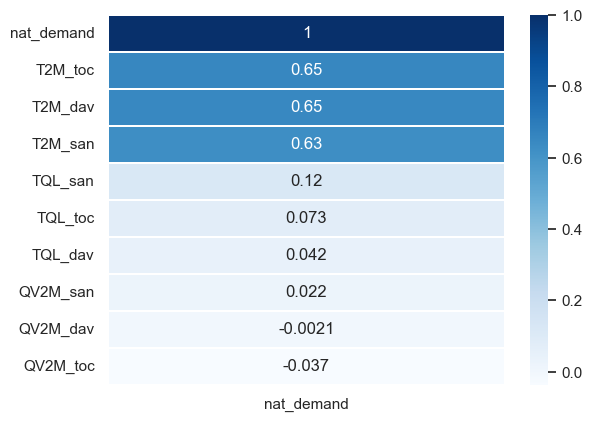

In [18]:
sns.heatmap(df.corr()[['nat_demand']].sort_values(by='nat_demand', ascending=False), cmap='Blues', annot=True, linewidths=0.25)

<AxesSubplot:>

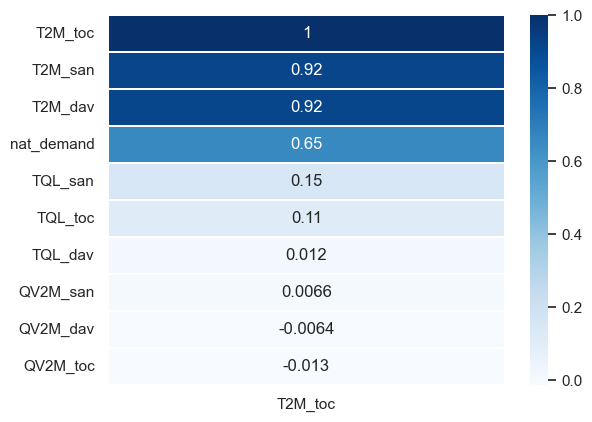

In [19]:
sns.heatmap(df.corr()[['T2M_toc']].sort_values(by='T2M_toc', ascending=False), cmap='Blues', annot=True, linewidths=0.25)

<AxesSubplot:>

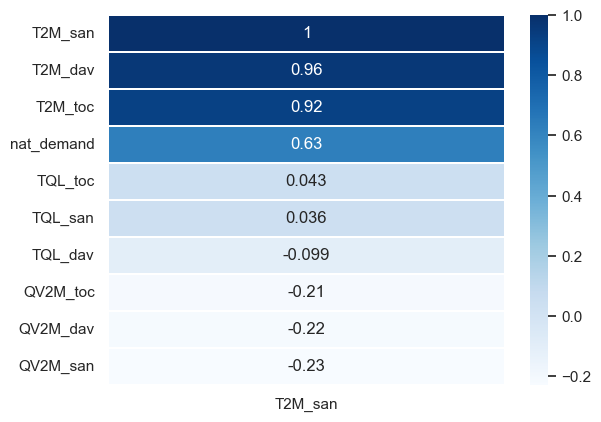

In [20]:
sns.heatmap(df.corr()[['T2M_san']].sort_values(by='T2M_san', ascending=False), cmap='Blues', annot=True, linewidths=0.25)

## Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [21]:
def sampling (bn, data, n):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [22]:
df_transformed = df.copy()
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(df.values[:])
df_transformed[:] = df_discretized

df_test = df_transformed.iloc[:10000, :].copy()
df_transformed = df_transformed.iloc[10000:,:].copy()

In [23]:
def get_scores(data, samples, descritizer=discretizer):

    data_continious = descritizer.inverse_transform(data.values)
    data_continious = pd.DataFrame(data_continious, columns=data.columns)
    sample_continious = descritizer.inverse_transform(samples.values)
    sample_continious = pd.DataFrame(sample_continious, columns=data.columns)

    y_true = np.sort(data_continious['nat_demand'].iloc[:10000].values)
    y_pred = np.sort(sample_continious['nat_demand'].iloc[:10000].values)

    corr_matrix = np.corrcoef(y_true, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2

    print(f'R-2 score is: {R_sq}')
    print(f'RMSE is: {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAE is: {mean_absolute_error(y_true, y_pred)}')
    print(f'MAPE is: {mean_absolute_percentage_error(y_true, y_pred)}')
    return R_sq, sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_percentage_error(y_true, y_pred)

In [24]:
data_rmse = []
data_mape = []
data_r2 = []

In [25]:
def create_edges(connections):

    edges = []
    for outlet, inlet in connections.items():
        for inl in inlet:
            edges.append([outlet, inl])
  
    return edges

connections = {
    'nat_demand': [],
    'T2M_toc': ['nat_demand'],
    'T2M_san': ['nat_demand', 'T2M_toc'],
    'QV2M_toc': [],
    'TQL_toc': [],
    'QV2M_san': ['QV2M_toc'], 
    'TQL_san': ['TQL_toc', 'QV2M_san'],
    'T2M_dav': ['nat_demand'],
    'QV2M_dav': ['QV2M_toc', 'QV2M_san', 'TQL_san'], 
    'TQL_dav': ['TQL_toc', 'QV2M_san', 'QV2M_dav']
}

edges = create_edges(connections)
vertices = ['nat_demand', 'T2M_toc', 'T2M_san', 'T2M_dav', 'TQL_san']
bn = {"V":vertices, "E":edges}

In [26]:
model = BayesianModel(edges)

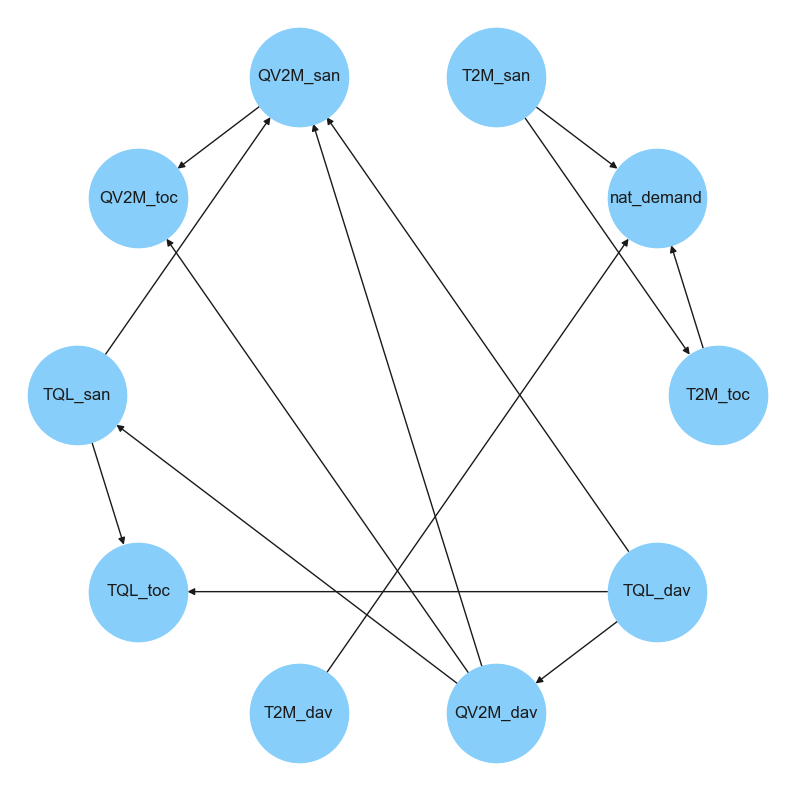

In [27]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(BayesianModel(edges).edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)
plt.savefig('3_2', dpi=300)

plt.show()

In [28]:
model.fit(df_transformed)

In [29]:
k2_scores = {}

k2_scores["manual"] = K2Score(df_transformed).score(model)
print(f"K2 score of hand-crafted model {K2Score(df_transformed).score(model):.2f}")
print(f"BIC score of hand-crafted model {BicScore(df_transformed).score(model):.2f}")

K2 score of hand-crafted model -685102.12
BIC score of hand-crafted model -774188.56


In [30]:
df_s1 = sampling(model, df_test, n=10000)
df_s1

Generating for node: QV2M_toc: 100%|██████████| 10/10 [00:00<00:00, 45.73it/s] 


,T2M_toc,nat_demand,T2M_san,QV2M_san,QV2M_toc,TQL_san,TQL_toc,T2M_dav,QV2M_dav,TQL_dav
0,1.0,1.0,2.0,8.0,6.0,3.0,4.0,1.0,7.0,2.0
1,3.0,1.0,2.0,7.0,6.0,1.0,3.0,1.0,7.0,3.0
2,5.0,0.0,4.0,8.0,8.0,3.0,4.0,9.0,8.0,2.0
3,7.0,7.0,8.0,8.0,7.0,5.0,7.0,3.0,9.0,5.0
4,1.0,1.0,2.0,6.0,4.0,2.0,4.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,3.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,5.0,3.0
9996,6.0,3.0,6.0,6.0,5.0,2.0,1.0,2.0,7.0,4.0
9997,3.0,5.0,2.0,7.0,5.0,0.0,0.0,6.0,8.0,4.0
9998,7.0,5.0,5.0,2.0,4.0,0.0,1.0,5.0,3.0,2.0


In [31]:
get_scores(df_transformed, df_s1, discretizer)

R-2 score is: 0.8863982869655092
RMSE is: 118.61472465920716
MAE is: 80.17759217448926
MAPE is: 0.07665396793701908


(0.8863982869655092, 118.61472465920716, 0.07665396793701908)

In [32]:
r2, rmse, mae = get_scores(df_transformed, df_s1, discretizer)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

R-2 score is: 0.8863982869655092
RMSE is: 118.61472465920716
MAE is: 80.17759217448926
MAPE is: 0.07665396793701908


## Step 5. Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

In [33]:
hc_search = HillClimbSearch(data=df_transformed)
hc_k2 = hc_search.estimate(scoring_method=K2Score(df_transformed))
hc_bic = hc_search.estimate(scoring_method=BicScore(df_transformed))

  0%|          | 11/1000000 [00:00<18:18:03, 15.18it/s]


In [34]:
k2_scores["k2_K2Score"] = K2Score(df_transformed).score(hc_k2)

print(f"K2 score of unconstrained model {K2Score(df_transformed).score(hc_k2):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_transformed).score(hc_k2):.2f}")

K2 score of unconstrained model -603935.41
BIC score of unconstrained model -628311.25


In [35]:
df_k2c = sampling(hc_k2, df_test, 10000)
get_scores(df_transformed, df_k2c, discretizer)

Generating for node: TQL_toc: 100%|██████████| 10/10 [00:00<00:00, 69.33it/s]

R-2 score is: 0.8844201753212957
RMSE is: 121.07446131698114
MAE is: 83.15674263740496
MAPE is: 0.07929592744094552


(0.8844201753212957, 121.07446131698114, 0.07929592744094552)

In [36]:
r2, rmse, mae = get_scores(df_transformed, df_k2c)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

R-2 score is: 0.8844201753212957
RMSE is: 121.07446131698114
MAE is: 83.15674263740496
MAPE is: 0.07929592744094552


In [37]:
k2_scores["k2_BicScore"] = BicScore(df_transformed).score(hc_bic)

print(f"K2 score of unconstrained model {K2Score(df_transformed).score(hc_bic):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_transformed).score(hc_bic):.2f}")

K2 score of unconstrained model -613287.45
BIC score of unconstrained model -618786.31


In [38]:
df_bic = sampling(hc_bic, df_test, 10000)
get_scores(df_transformed, df_bic, discretizer)

Generating for node: TQL_toc: 100%|██████████| 10/10 [00:00<00:00, 118.45it/s]

R-2 score is: 0.9019973172809127
RMSE is: 100.7782447422997
MAE is: 78.74467406818606
MAPE is: 0.07208794665481955


(0.9019973172809127, 100.7782447422997, 0.07208794665481955)

In [39]:
r2, rmse, mae = get_scores(df_transformed, df_bic)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

R-2 score is: 0.9019973172809127
RMSE is: 100.7782447422997
MAE is: 78.74467406818606
MAPE is: 0.07208794665481955


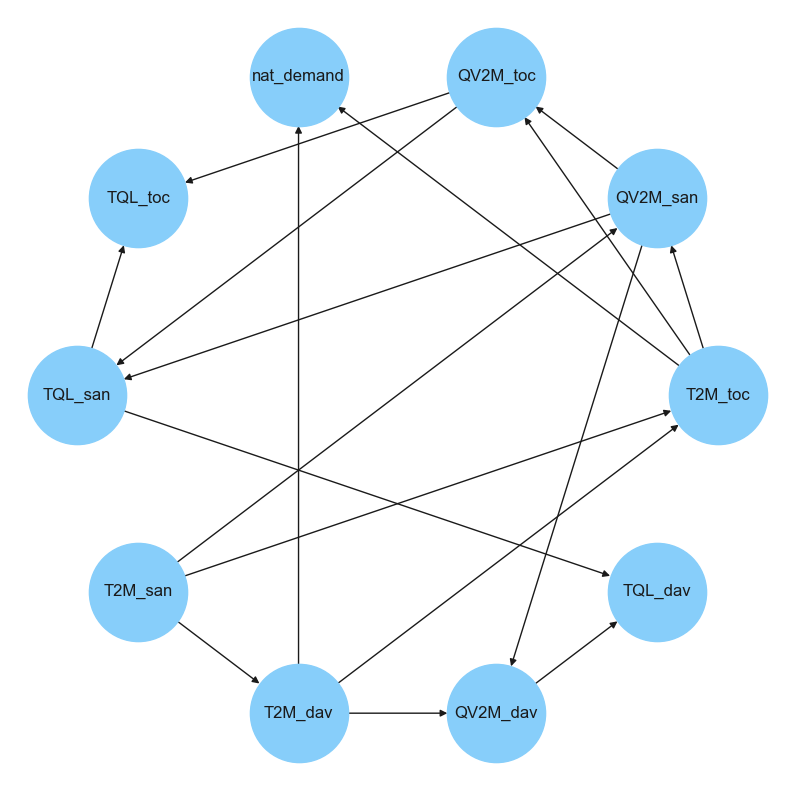

In [40]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_k2.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.savefig('3_3', dpi=300)

plt.show()

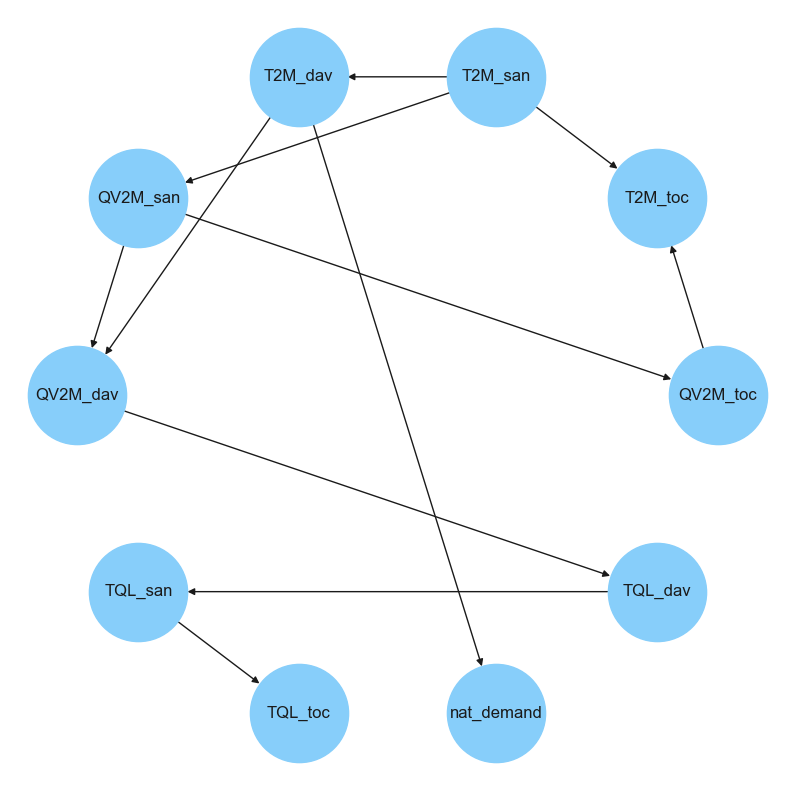

In [41]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_bic.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.savefig('3_4', dpi=300)

plt.show()

In [42]:
e_search = TreeSearch(data=df_transformed)
e_model = e_search.estimate()

Building tree: 100%|██████████| 45/45.0 [00:00<00:00, 834.00it/s]


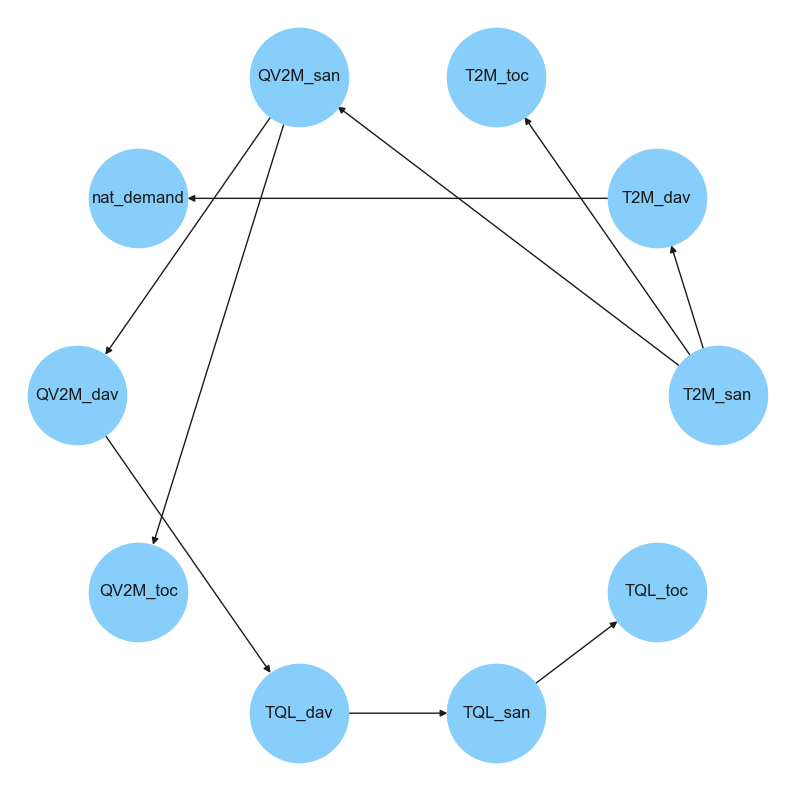

In [43]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(e_model.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.savefig('3_5', dpi=300)

plt.show()

In [44]:
k2_scores["tree"] = K2Score(df_transformed).score(e_model)

print(f"K2 score of tree model {K2Score(df_transformed).score(e_model):.2f}")
print(f"BIC score of tree model {BicScore(df_transformed).score(e_model):.2f}")

K2 score of tree model -620920.88
BIC score of tree model -621939.67


In [45]:
df_tree = sampling(e_model, df_test, n=10000)
get_scores(df_transformed, df_tree)

Generating for node: TQL_toc: 100%|██████████| 10/10 [00:00<00:00, 152.52it/s]

R-2 score is: 0.8766962882071689
RMSE is: 146.8877856256853
MAE is: 115.44614822226426
MAPE is: 0.10831252260033485


(0.8766962882071689, 146.8877856256853, 0.10831252260033485)

In [46]:
r2, rmse, mae = get_scores(df_transformed, df_tree)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

R-2 score is: 0.8766962882071689
RMSE is: 146.8877856256853
MAE is: 115.44614822226426
MAPE is: 0.10831252260033485


##  Step 6. Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

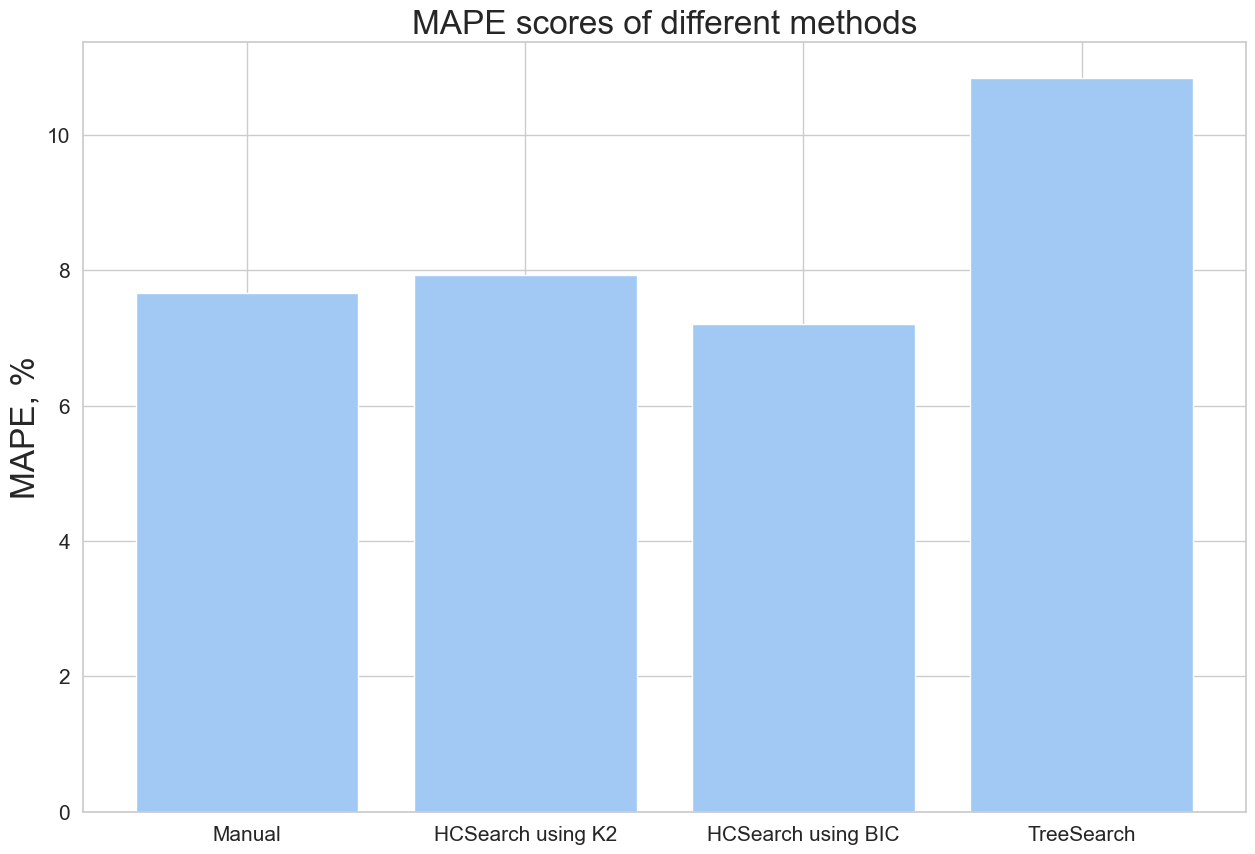

In [47]:
plt.figure(figsize=(15, 10))
x = ["Manual", "HCSearch using K2", "HCSearch using BIC", 'TreeSearch']

plt.bar(x, [i*100 for i in data_mape])
plt.title('MAPE scores of different methods', fontsize=24)
plt.ylabel('MAPE, %', fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('3_6', dpi=300)

plt.show()

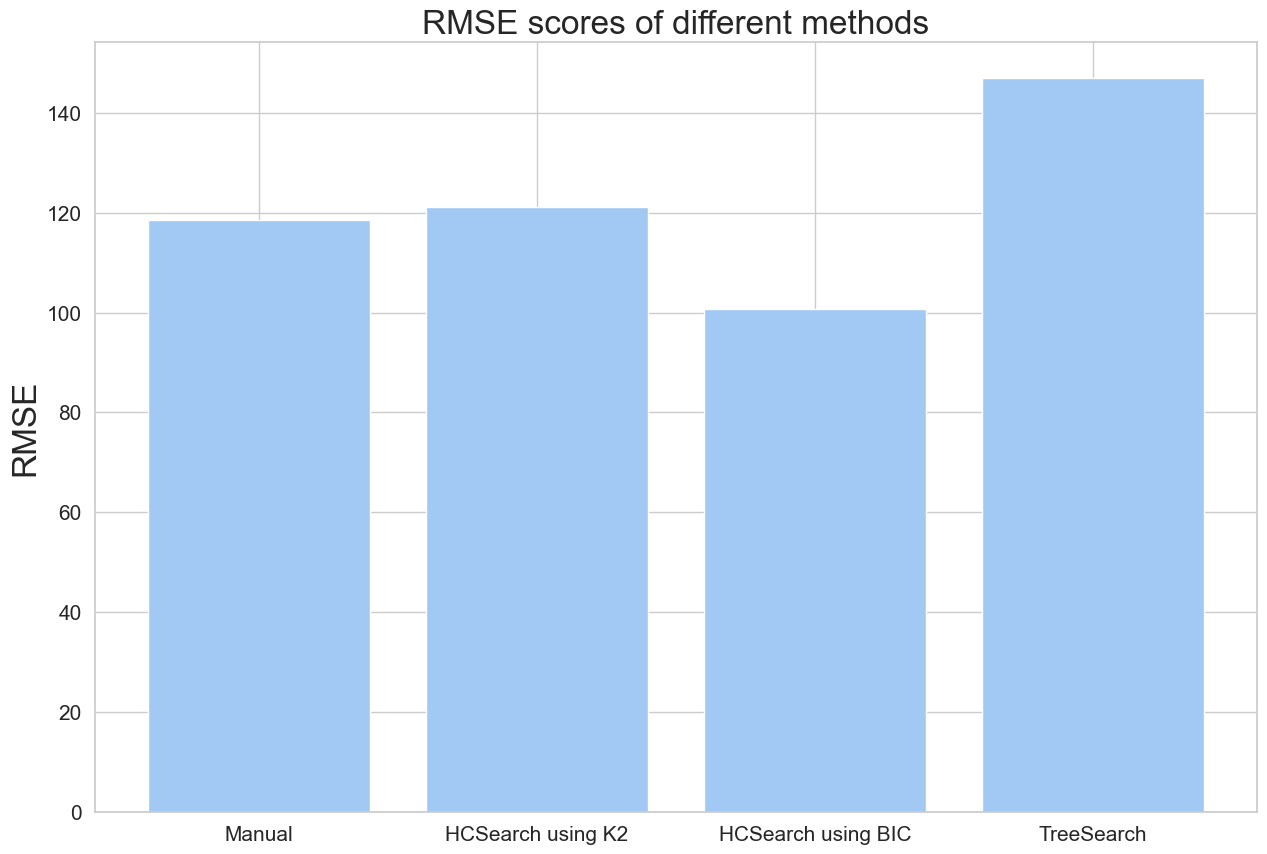

In [48]:
plt.figure(figsize=(15, 10))
x = ["Manual", "HCSearch using K2", "HCSearch using BIC", 'TreeSearch']

plt.bar(x, data_rmse)
plt.title('RMSE scores of different methods', fontsize=24)
plt.ylabel('RMSE', fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('3_7', dpi=300)

plt.show()

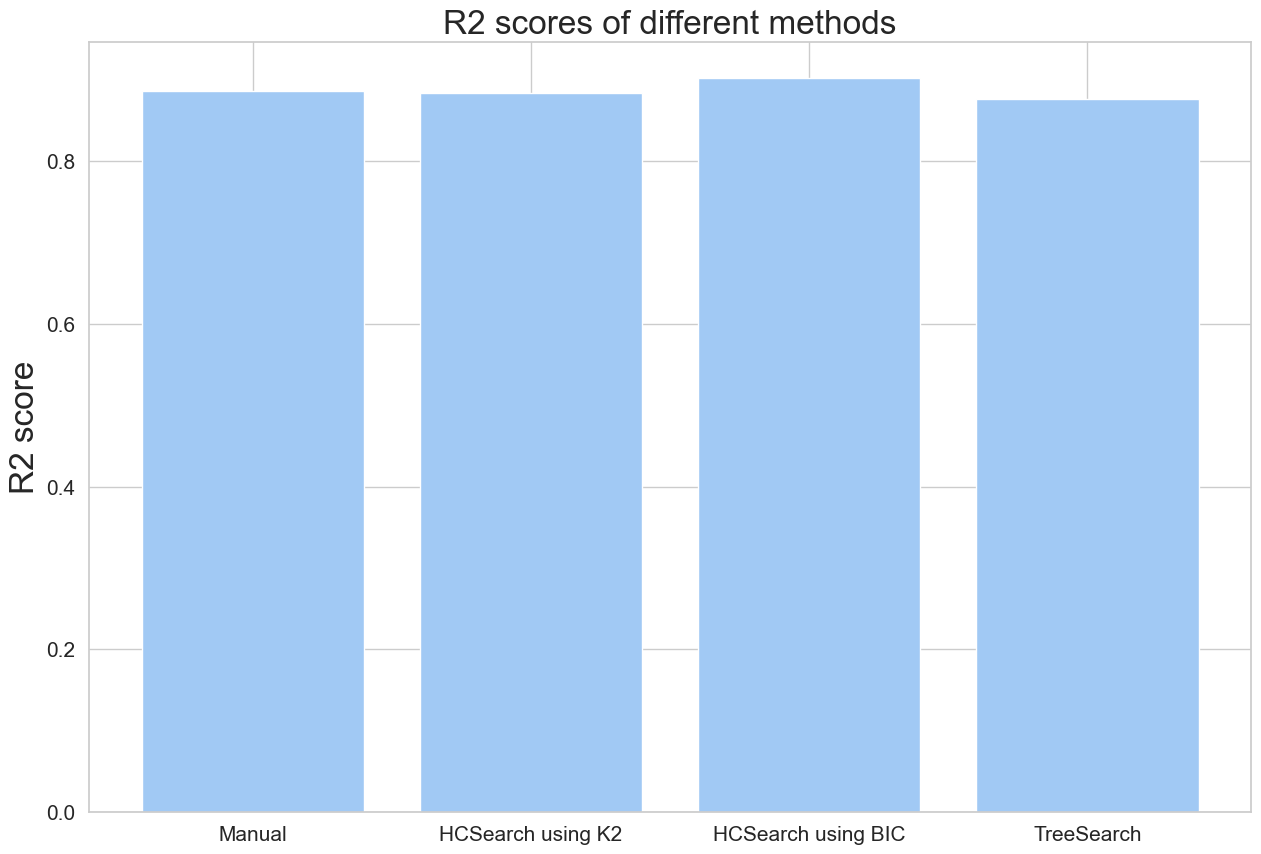

In [49]:
plt.figure(figsize=(15, 10))
x = ["Manual", "HCSearch using K2", "HCSearch using BIC", 'TreeSearch']

plt.bar(x, data_r2)
plt.title('R2 scores of different methods', fontsize=24)
plt.ylabel('R2 score', fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('3_8', dpi=300)

plt.show()

In [50]:
def draw_comparative_hist (parametr, original_data, data_sampled, axes=None):
    final_df = pd.DataFrame()
    
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    
    sns.barplot(ax=axes, x=parametr, y="Probability", hue="Data", data=final_df, palette='Blues')

In [51]:
sample_K2 = sampling(hc_k2, df_transformed, df_transformed.shape[0])
sample_Bic = sampling(hc_bic, df_transformed, df_transformed.shape[0])

Generating for node: TQL_toc: 100%|██████████| 10/10 [00:00<00:00, 41.63it/s]


In [52]:
df_transformed.shape[0]

38048

In [53]:
print(classification_report(df_transformed.nat_demand, sample_K2.nat_demand))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.03      0.03      0.03      1440
         2.0       0.12      0.12      0.12      4521
         3.0       0.14      0.14      0.14      5282
         4.0       0.13      0.12      0.13      4968
         5.0       0.13      0.13      0.13      5002
         6.0       0.14      0.14      0.14      5366
         7.0       0.12      0.12      0.12      4647
         8.0       0.11      0.11      0.11      4022
         9.0       0.07      0.07      0.07      2793

    accuracy                           0.12     38048
   macro avg       0.10      0.10      0.10     38048
weighted avg       0.12      0.12      0.12     38048



In [54]:
print(classification_report(df_transformed.nat_demand, sample_Bic.nat_demand))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.03      0.03      0.03      1440
         2.0       0.12      0.12      0.12      4521
         3.0       0.13      0.13      0.13      5282
         4.0       0.12      0.12      0.12      4968
         5.0       0.13      0.12      0.13      5002
         6.0       0.14      0.14      0.14      5366
         7.0       0.12      0.13      0.13      4647
         8.0       0.10      0.10      0.10      4022
         9.0       0.06      0.06      0.06      2793

    accuracy                           0.12     38048
   macro avg       0.10      0.10      0.10     38048
weighted avg       0.12      0.12      0.12     38048



In [55]:
print(classification_report(df_transformed.T2M_toc, sample_K2.T2M_toc))

              precision    recall  f1-score   support

         0.0       0.06      0.06      0.06      2250
         1.0       0.13      0.13      0.13      5087
         2.0       0.18      0.18      0.18      6703
         3.0       0.16      0.16      0.16      6212
         4.0       0.13      0.13      0.13      4930
         5.0       0.12      0.12      0.12      4306
         6.0       0.11      0.11      0.11      3689
         7.0       0.07      0.07      0.07      2681
         8.0       0.03      0.03      0.03      1491
         9.0       0.02      0.02      0.02       699

    accuracy                           0.13     38048
   macro avg       0.10      0.10      0.10     38048
weighted avg       0.13      0.13      0.13     38048



In [56]:
print(classification_report(df_transformed.T2M_toc, sample_Bic.T2M_toc))

              precision    recall  f1-score   support

         0.0       0.06      0.06      0.06      2250
         1.0       0.14      0.14      0.14      5087
         2.0       0.17      0.17      0.17      6703
         3.0       0.16      0.15      0.15      6212
         4.0       0.13      0.13      0.13      4930
         5.0       0.12      0.12      0.12      4306
         6.0       0.10      0.11      0.11      3689
         7.0       0.08      0.08      0.08      2681
         8.0       0.03      0.03      0.03      1491
         9.0       0.02      0.02      0.02       699

    accuracy                           0.12     38048
   macro avg       0.10      0.10      0.10     38048
weighted avg       0.12      0.12      0.12     38048



In [57]:
print(classification_report(df_transformed.T2M_san, sample_K2.T2M_san))

              precision    recall  f1-score   support

         0.0       0.05      0.05      0.05      2017
         1.0       0.16      0.16      0.16      6117
         2.0       0.23      0.23      0.23      8452
         3.0       0.16      0.16      0.16      6008
         4.0       0.13      0.13      0.13      4795
         5.0       0.12      0.12      0.12      4477
         6.0       0.08      0.08      0.08      3026
         7.0       0.03      0.03      0.03      1242
         8.0       0.02      0.02      0.02      1093
         9.0       0.01      0.01      0.01       821

    accuracy                           0.14     38048
   macro avg       0.10      0.10      0.10     38048
weighted avg       0.14      0.14      0.14     38048



In [58]:
print(classification_report(df_transformed.T2M_san, sample_Bic.T2M_san))

              precision    recall  f1-score   support

         0.0       0.05      0.05      0.05      2017
         1.0       0.16      0.16      0.16      6117
         2.0       0.22      0.21      0.22      8452
         3.0       0.16      0.16      0.16      6008
         4.0       0.13      0.13      0.13      4795
         5.0       0.12      0.12      0.12      4477
         6.0       0.08      0.08      0.08      3026
         7.0       0.03      0.03      0.03      1242
         8.0       0.02      0.02      0.02      1093
         9.0       0.02      0.02      0.02       821

    accuracy                           0.14     38048
   macro avg       0.10      0.10      0.10     38048
weighted avg       0.14      0.14      0.14     38048



In [59]:
sample_K2[sample_K2.columns] = discretizer.inverse_transform(sample_K2[sample_K2.columns].values)
sample_Bic[sample_Bic.columns] = discretizer.inverse_transform(sample_Bic[sample_Bic.columns].values)
sample_K2.columns = df.columns
sample_Bic.columns = df.columns

In [60]:
df_1 = df.sample(100, random_state=41)
sample_K2_1 = sample_K2.sample(100, random_state=41)
sample_Bic_1 = sample_Bic.sample(100, random_state=41)

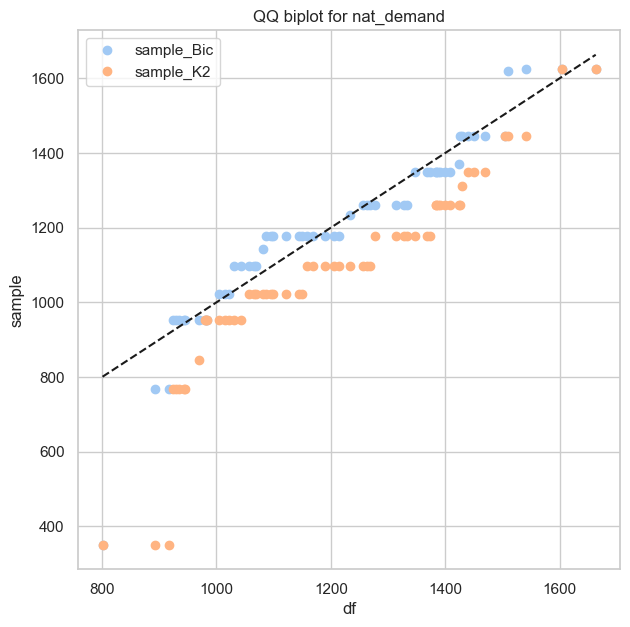

Results of Kolmogorov test = (0.21117008625127576, 0.0002248739317492479)
Mann–Whitney U Test: p-value = (0.9892643899744807, 0.0011464987284778032)


In [61]:
percs = np.linspace(0, 1, 60)
qn_1 = np.quantile(df_1['nat_demand'], percs)
qn_2 = np.quantile(sample_Bic_1['nat_demand'], percs)
qn_3 = np.quantile(sample_K2_1['nat_demand'], percs)


x = np.linspace(np.min(df_1['nat_demand']), np.max(df_1['nat_demand']))

f = plt.figure(figsize=(7, 7))
plt.plot(qn_1, qn_2, ls="", marker="o", markersize=6, label = 'sample_Bic')
plt.plot(qn_1, qn_3, ls="", marker="o", markersize=6, label = 'sample_K2')

plt.plot(x, x, color="k", ls="--")
plt.title('QQ biplot for nat_demand')
plt.xlabel(f'df')
plt.ylabel('sample')
plt.legend(loc = 'upper left')
plt.savefig('3_09', dpi=300)
plt.show()

p1_1 = scipy.stats.kstest(df_1['nat_demand'], sample_Bic_1['nat_demand']).pvalue
p1_2 = scipy.stats.mannwhitneyu(df_1['nat_demand'], sample_Bic_1['nat_demand']).pvalue

p2_1 = scipy.stats.kstest(df_1['nat_demand'], sample_K2_1['nat_demand']).pvalue
p2_2 = scipy.stats.mannwhitneyu(df_1['nat_demand'], sample_K2_1['nat_demand']).pvalue

print('Results of Kolmogorov test =', (p1_1, p2_1))
print('Mann–Whitney U Test: p-value =', (p1_2, p2_2))

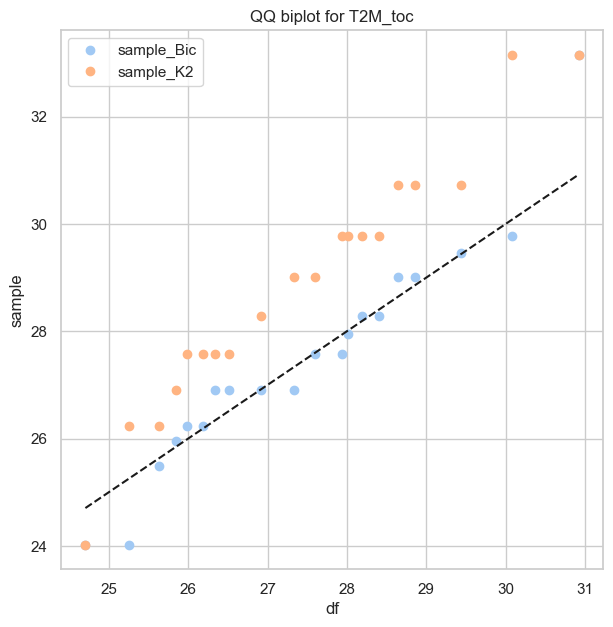

Results of Kolmogorov test = (0.469506448503778, 1.1151678185620634e-08)
Mann–Whitney U Test: p-value = (0.9249706244484944, 9.573235145973592e-08)


In [62]:
percs = np.linspace(0, 1, 20)
qn_1 = np.quantile(df_1['T2M_toc'], percs)
qn_2 = np.quantile(sample_Bic_1['T2M_toc'], percs)
qn_3 = np.quantile(sample_K2_1['T2M_toc'], percs)

x = np.linspace(np.min(df_1['T2M_toc']), np.max(df_1['T2M_toc']))

f = plt.figure(figsize=(7, 7))
plt.plot(qn_1, qn_2, ls="", marker="o", markersize=6, label = 'sample_Bic')
plt.plot(qn_1, qn_3, ls="", marker="o", markersize=6, label = 'sample_K2')

plt.plot(x, x, color="k", ls="--")
plt.title('QQ biplot for T2M_toc')
plt.xlabel(f'df')
plt.ylabel('sample')
plt.legend(loc = 'upper left')
plt.savefig('3_010', dpi=300)
plt.show()


p1_1 = scipy.stats.kstest(df_1['T2M_toc'], sample_Bic_1['T2M_toc']).pvalue
p1_2 = scipy.stats.mannwhitneyu(df_1['T2M_toc'], sample_Bic_1['T2M_toc']).pvalue

p2_1 = scipy.stats.kstest(df_1['T2M_toc'], sample_K2_1['T2M_toc']).pvalue
p2_2 = scipy.stats.mannwhitneyu(df_1['T2M_toc'], sample_K2_1['T2M_toc']).pvalue

print('Results of Kolmogorov test =', (p1_1, p2_1))
print('Mann–Whitney U Test: p-value =', (p1_2, p2_2))

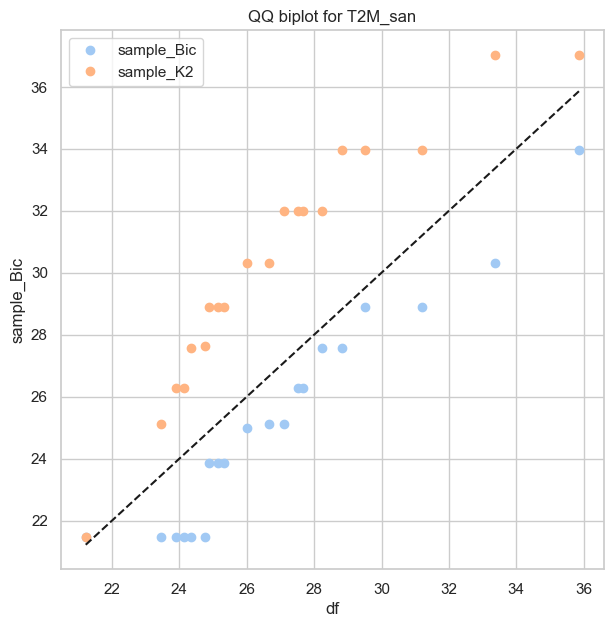

Results of Kolmogorov test = (1.7527190839835072e-06, 1.070075869779788e-12)
Mann–Whitney U Test: p-value = (0.00012594458165595331, 6.2758450276596835e-12)


In [63]:
percs = np.linspace(0, 1, 20)
qn_1 = np.quantile(df_1['T2M_san'], percs)
qn_2 = np.quantile(sample_K2_1['T2M_san'], percs)
qn_3 = np.quantile(sample_Bic_1['T2M_san'], percs)

x = np.linspace(np.min(df_1['T2M_san']), np.max(df_1['T2M_san']))

f = plt.figure(figsize=(7, 7))
plt.plot(qn_1, qn_2, ls="", marker="o", markersize=6, label = 'sample_Bic')
plt.plot(qn_1, qn_3, ls="", marker="o", markersize=6, label = 'sample_K2')

plt.plot(x, x, color="k", ls="--")
plt.title('QQ biplot for T2M_san')
plt.xlabel(f'df')
plt.ylabel('sample_Bic')
plt.legend(loc = 'upper left')
plt.savefig('3_011', dpi=300)
plt.show()

p1_1 = scipy.stats.kstest(df_1['T2M_san'], sample_K2_1['T2M_san']).pvalue
p1_2 = scipy.stats.mannwhitneyu(df_1['T2M_san'], sample_K2_1['T2M_san']).pvalue

p2_1 = scipy.stats.kstest(df_1['T2M_san'], sample_Bic_1['T2M_san']).pvalue
p2_2 = scipy.stats.mannwhitneyu(df_1['T2M_san'], sample_Bic_1['T2M_san']).pvalue

print('Results of Kolmogorov test =', (p1_1, p2_1))
print('Mann–Whitney U Test: p-value =', (p1_2, p2_2))